#### Import Libraries

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

The true data generating process for a series $\lbrace x_t \rbrace_{t=1}^{T=200}$ is given by the following AR(1) model:
$$ x_t = \rho_0 x_{t−1} + \epsilon_t, \qquad \epsilon_t \sim N(0,1)$$

where $\rho_0 = 0.5$ and $x_0 = 0$.

The model generation process will be:
$$ y_t(b) = \rho y_{t-1}(b) + e_t, \qquad e_t \sim N(0,\sigma^2) $$

Where $b = (\rho, \sigma^2)$

<ins>Since we do not know the true parameter vector of b, we will estimate it using the simulated method of moments.<ins>

- The **first step** is to define $m$, which denotes a mapping from a $ 1 \times 1 $ vector $ z_t $ (either true data or model-generated pseudodata) to an $ n \times 1 $ moment vector.

We set $n = 3$ and construct the mean, variance, and first-order autocovariance using the following matrix:

$$ m_3(z_t) =\begin{bmatrix}
z_t\\
(z_t-\bar{z})^2\\
(z_t-\bar{z})(z_{t-1}-\bar{z})
\end{bmatrix}$$

- The **second step** is to calculate these three asymptotic moments. The following operations are related to the calculation of these moments:

---

- **Moment of Mean:**
$$E[x_t] = E[\rho_0 x_{t-1}+\epsilon_t]=\rho_0 E[x_{t-1}]+E[\epsilon_t]$$
 Since $E[\epsilon_t]=0$ and $E[x_{0}]=E[0]=0$

$$E[x_t] = 0 \qquad \text{for all}\quad t$$

---

- **Moment of Variance:**
$$\operatorname{Var}[x_t] = E[x_t^2] - (E[x_t])^2 \xRightarrow[{}]{E[x_t]=0} \operatorname{Var}[x_t] = E[x_t^2] $$

$$ E[x_t^2] = E[(\rho_0 x_{t-1}+\epsilon_t)^2] = \rho_0^2 E[x_{t-1}^2] + 2\rho_0 E[x_{t-1}\epsilon_t] + E[\epsilon^2] $$

 Since $\epsilon_t$ is indipendent of $x_{t-1}$ and $E[\epsilon_t]=0$

 $$ E[x_{t-1}\epsilon_t] = E[x_{t-1}]E[\epsilon_t] = 0 $$

 $$ E[x_t^2] = \rho_0^2 E[x_{t-1}^2] + E[\epsilon^2] \rightarrow var = \rho_0^2 var + \sigma_0^2 $$

 Solving for $var$:
 $$ var = \dfrac{\sigma_0^2}{(1-\rho_0^2)} $$
***

- **Moment of First-order Autocovariance:**

$$ \operatorname{Cov}[x_t, x_{t-1}] = E[x_t x_{t-1}] - E[x_t] E[x_{t-1}] \xRightarrow[]{E[x_t]=0} E[x_t x_{t-1}] $$

$$ E[x_t x_{t-1}] = E[(\rho_0 x_{t-1} + \varepsilon_t) x_{t-1}] = \rho_0 E[x_{t-1}^2] + E[\varepsilon_t x_{t-1}] $$

Since $ \varepsilon_t $ is independent of $ x_{t-1} $:

$$ E[x_t x_{t-1}] = \rho_0 E[x_{t-1}^2] = \rho_0 var $$

Then We have,

$$ \operatorname{Cov}[x_t, x_{t-1}] = \rho_0 \times \left( \frac{\sigma_0^2}{1 - \rho_0^2} \right) $$

---

We can write the population (unconditional) moment vector for the true data using $m$ as $\mu(x) = E[m(x)]$.

### **Asymptotic Moments:**

- The population data moments are:
$$ \mu(x) =
\begin{bmatrix}
0\\
\dfrac{\sigma_0^2}{1-\rho_0^2}\\
\rho_0 \times \left( \frac{\sigma_0^2}{1 - \rho_0^2} \right)
\end{bmatrix}=
\begin{bmatrix}
0\\
\dfrac{4}{3}\\
\dfrac{2}{3}
\end{bmatrix}$$

- The Population model moments are:
$$
\mu(y(b)) = \begin{bmatrix}
0\\
\dfrac{\sigma^2}{1-\rho^2}\\
\rho \times \left( \frac{\sigma^2}{1 - \rho^2} \right)
\end{bmatrix}$$

---

### **Computation of $ \nabla_b g(b_0)$:**

To calculate $ \nabla_b g(b_0)$, we must compute the partial derivatives of each moment with respect to $\rho$ and $\sigma$.

- **Moment of Mean:**

$$ \dfrac{\partial E[x_t]}{\partial \rho} = \dfrac{\partial E[x_t]}{\partial \sigma} = 0 $$

---
- **Moment of Variance:**

$$ \dfrac{\partial Var[x_t]}{\partial \rho} = \dfrac{2\rho \sigma^2}{(1-\rho^2)^2}$$

$$ \dfrac{\partial Var[x_t]}{\partial \sigma} = \dfrac{2\sigma}{(1-\rho^2)}$$

---
- **Moment of First-Order Autocovariance:**

$$ \dfrac{\partial Cov[x_t,x_{t-1}]}{\partial \rho} = \dfrac{\sigma^2}{1-\rho^2} + \dfrac{2\sigma^2 \rho^2}{(1-\rho^2)^2} = \frac{\sigma^2 (1 + \rho^2)}{(1 - \rho^2)^2}
$$

$$ \dfrac{\partial Cov[x_t,x_{t-1}]}{\partial \sigma} = \rho \times \dfrac{2\sigma}{(1-\rho^2)}$$

---

A moment is considered informative for estimating a parameter if its derivative with respect to that parameter is non-zero. From the derivations above, we can see that the moment of the mean is not informative, whereas the moments of variance and autocovariance contain valuable information that can help us in the Simulated Method of Moments (SMM) approach.

### **Simulate a series of “true” data**
Set the Parameters

In [77]:
rho = 0.5
T = 200

To construct the AR(1) process, start by:
- Create an initial array X
- Generate T random number from a normal distribution

In [78]:
np.random.seed(111)
x = np.zeros(T+1)
x[0] = 0
eps = np.random.normal(0,1,T+1)

for t in range(1,T+1):
    x[t] = rho * x[t-1] + eps[t]

x = x[1:]

Plot the true data for the AR(1) process

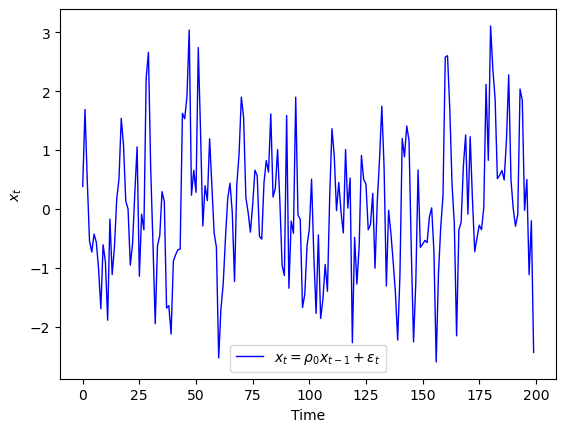

In [79]:
plt.Figure()
plt.plot(x, label=r"$x_t = \rho_0 x_{t-1} + \varepsilon_t$", color = "blue", linewidth=1)
plt.xlabel("Time")
plt.ylabel("$x_t$")
plt.legend()
plt.show()

---

### **True Data Moments: $M_T(x)$**

$$ M_T(x) = \dfrac{1}{T}\sum_{t=1}^T m_3(x_t)$$

In [80]:
xbar = np.mean(x)
m3x = np.zeros((3,T))

for t in range(T):
    m3x[0,t] = x[t] 
    m3x[1,t] = (x[t] - xbar)**2
    
    if t == 0 :
        x_prev = 0
    else :
        x_prev = x[t - 1]
        
    m3x[2,t] = (x[t] - xbar)*(x_prev - xbar)

MT_x = np.mean(m3x, axis = 1) 
MT_x

array([0.02300667, 1.31465318, 0.66651158])

---

### **Simulated Data Moments: $ M_{TH}(y(b)) $**

- $e_t$: Contructing a matrix of random white noise $ \rightarrow e_{10 \times 200}$
- simul_data: Use $\rho$ and $\sigma$ to create a $(10 \times 200)$ matrix, resulting in 10 simulated time series, each with $T$ observations.

$$y_{i,j} = \rho \times y_{i,j-1} + \sigma \times e_{i,j}$$
 - $i$ in range $H$
 - $j$ in range $(1, T+1)$

In [81]:
np.random.seed(111)
H = 10
e = np.random.normal(0, 1, (H, T + 1))

def simul_data(rho, sigma):
    y = np.zeros((H, T + 1))
    for i in range(H):
        for j in range(1, T + 1):
            y[i][j] = rho * y[i][j - 1] + sigma * e[i][j]
    y = y[:, 1:]
    return y

- Calculate the three moments of the simulated data using $\rho$ and $\sigma$.
- Compute the mean across $H$ simulations and $T$ observations.

$$M_{TH} (y(b)) = \dfrac{1}{TH} \sum_{t=1}^T \sum_{h=1}^H  m_3(y_t^h(b))$$

In [82]:
def simul_moment(rho,sigma):
    y = simul_data(rho, sigma)
    y_bar = []
    m3y = np.zeros((3,H,T))

    for h in range(H):
        y_bar.append(np.mean(y[h]))
        for t in range(T):
            m3y[0,h,t] = y[h][t]
            m3y[1,h,t] = (y[h][t] - y_bar[h])**2
            if t == 0:
                y_prev = 0
            else:
                y_prev = (y[h][t-1])
            m3y[2,h,t] = (y[h][t] - y_bar[h])*(y_prev - y_bar[h])

    MTH_y = []
    for i in range(3):
        MTH_y.append(np.mean(m3y[i], axis = 0))
    MTH_y = np.mean(MTH_y, axis = 1)

    return (MTH_y, m3y)

---

Let the objective function be given by:

$$
J_{TH}(b) \equiv [M_T(x) - M_{T_H}(y(b))]' \, W \, [M_T(x) - M_{T_H}(y(b))]
$$
where;
- $g_{TH}(b) ≡ M_T(x) - M_{TH}(y(b))$ is an $n \times 1$ vector with the distance between data moments and model moments
- $W$ is a positive semi-definite weighting matrix.

The SMM estimate $\hat{b}_{TH}$,
$$
\hat{b}_{TH} = \arg \min_b J_{TH}(b)
$$

In [83]:
def obj_func(par_ls, w = np.eye(3), moment_idx=[0,1,2]):
    rho , sigma = par_ls
    MTH_y = simul_moment(rho, sigma)[0].reshape(-1,1)
    MT_x1 = MT_x.reshape(-1,1)
    MTH_y = MTH_y[moment_idx]
    MT_x1 = MT_x1[moment_idx]
    diff = MT_x1 - MTH_y
    JTH = diff.T @ w @ diff
    return JTH.item()

---

### **Just Identified Case $m_2(x)$**

**Plot Objective Function vs $\sigma$**

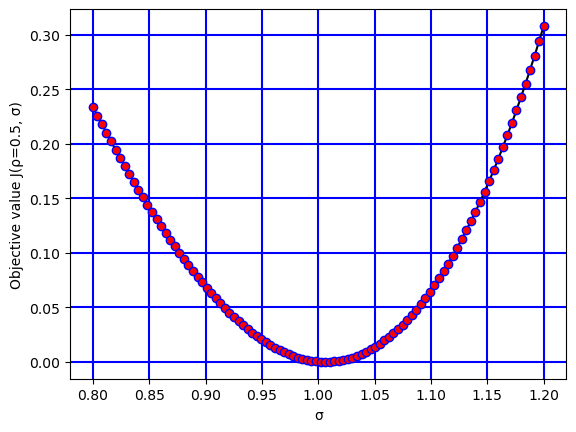

In [84]:
rho_fixed = 0.5
sigma_vals = np.linspace(0.8, 1.2, 100)

J_vals = [obj_func([rho_fixed, s], w=np.eye(2), moment_idx=[0, 1]) for s in sigma_vals]

plt.figure()
plt.plot(sigma_vals, J_vals, marker='.', markersize=12,
    markerfacecolor='red', markeredgecolor='blue',
    linestyle='-', color='black')
plt.xlabel("σ")
plt.ylabel("Objective value J(ρ=0.5, σ)")
plt.grid(True, color='blue', linewidth=1.5)
plt.show()

**Plot Objective Function vs $\rho$**

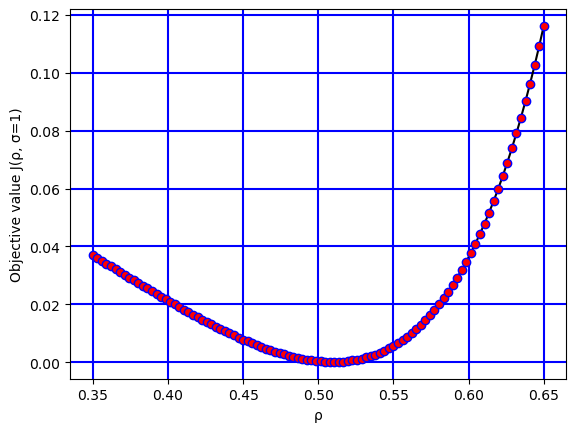

In [85]:
sigma_fixed = 1.0
rho_vals = np.linspace(0.35, 0.65, 100)
J_vals = [obj_func([r, sigma_fixed], w=np.eye(2), moment_idx=[0, 1]) for r in rho_vals]

plt.figure()
plt.plot(rho_vals, J_vals, marker='.', markersize=12,
    markerfacecolor='red', markeredgecolor='blue',
    linestyle='-', color='black')
plt.xlabel("ρ")
plt.ylabel("Objective value J(ρ, σ=1)")
plt.grid(True, color="b", linewidth=1.5)
plt.show()

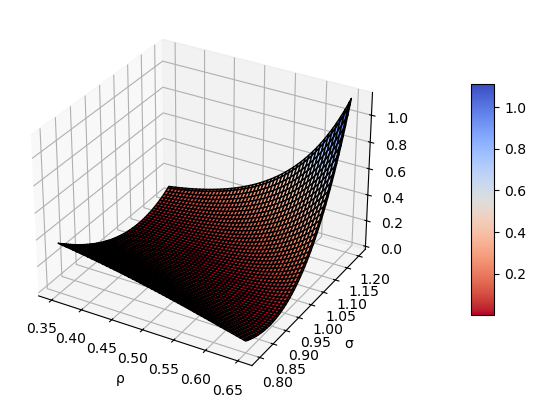

In [ ]:
Rho, Sigma = np.meshgrid(rho_vals, sigma_vals)

J = np.zeros_like(Rho)
for i in range(Rho.shape[0]):
    for j in range(Rho.shape[1]):
        J[i, j] = obj_func([Rho[i, j], Sigma[i, j]], w=np.eye(2), moment_idx=[0, 1])

fig3D = plt.figure(figsize=(7, 6))
ax = fig3D.add_subplot(111, projection = '3d')
surface = ax.plot_surface(Rho, Sigma, J, cmap = "coolwarm_r", edgecolor = "k")

ax.set_xlabel('ρ')
ax.set_ylabel('σ')

fig3D.colorbar(surface, shrink=0.5, aspect=10, pad=0.15)
plt.show()